Use [bboxfinder](http://bboxfinder.com/) to draw boundary box around SF and Oakland.

# Get all stop stations within bounding box

In [1]:
import requests

In [2]:
%%time

mapzen_api_key = "mapzen-ai1duha"
bbox = "-122.699432,37.665070,-122.211227,37.861302"
response = requests.get("http://transit.land/api/v1/stop_stations?bbox={}&api_key={}&per_page=false&total=true".format(bbox, mapzen_api_key))
json_response = response.json()

print json_response['meta']['total'], "stop_stations in bounding box"
print len(json_response['stop_stations']), "stop_stations in json response"

5669 stop_stations in bounding box
5669 stop_stations in json response
CPU times: user 425 ms, sys: 70.9 ms, total: 495 ms
Wall time: 52.5 s


# Classify each stop station as either "simple stop" or "station"

In [3]:
def classify_stop_station_types(json_input):
    
    for stop_station in json_input['stop_stations']:
        generated_or_not_generated = []
    
        for stop_egress in stop_station['stop_egresses']:
            generated_or_not_generated.append(stop_egress['generated'])

        for stop_platform in stop_station['stop_platforms']:
            generated_or_not_generated.append(stop_platform['generated'])

        # if a particular station has all stop egresses and stop platforms with
        # generated = true, then it's just a simple stop. otherwise, its a station
        
        if all(generated_or_not_generated):
            stop_station['stop_station_type'] = "Simple Stop"
        else:
            stop_station['stop_station_type'] = "Station"
            
    return json_input

In [4]:
data = classify_stop_station_types(json_response)

# Get all of the stop stations for the map

In [5]:
def get_stop_stations_for_map(json_input):
    output = []
    for i in json_input['stop_stations']:
        results = {}
        results['stop_station_lon'] = i['geometry']['coordinates'][0]
        results['stop_station_lat'] = i['geometry']['coordinates'][1]
        results['stop_station_name'] = str(i['name']).replace('"',"")
        results['operators_serving_stop_and_platforms'] = [str(j['operator_name']) for j in i['operators_serving_stop_and_platforms']]
        results['onestop_id'] = i['onestop_id']
        
        if i['stop_station_type'] == 'Station':
            if len(i['stop_platforms']) == 0:
                results['stop_station_type'] = 'Station w 0 Platforms'
            elif len(i['stop_platforms']) == 1:
                results['stop_station_type'] = 'Station w 1 Platform'
            elif len(i['stop_platforms']) == 2:
                results['stop_station_type'] = 'Station w 2 Platforms'
            elif len(i['stop_platforms']) > 2:
                results['stop_station_type'] = 'Station w >2 Platforms'            
        else:        
            results['stop_station_type'] = 'Simple Stop'

        results['number_of_stop_platforms'] = len(i['stop_platforms'])             
                
        output.append(results)
    
    return output

In [6]:
stop_stations_for_map = get_stop_stations_for_map(data)

# Get all of the stop platforms for the map

In [7]:
def get_stop_platforms_for_map(json_input):
    output = []
    for i in json_input['stop_stations']:
        for stop_platform in i['stop_platforms']:
            platform = {}
            if stop_platform['generated'] == False:
                platform['parent_station_id'] = i['onestop_id']
                platform['parent_station_name'] = i['name']
                platform['stop_platform_lon'] = stop_platform['geometry']['coordinates'][0]
                platform['stop_platform_lat'] = stop_platform['geometry']['coordinates'][1]
                platform['operators_serving_stop_and_platforms'] = i['operators_serving_stop_and_platforms']
                platform['stop_station_type'] = "Stop Platform"
                platform['onestop_id'] = stop_platform['onestop_id']
                output.append(platform)                    
    return output

In [8]:
stop_platforms_for_map = get_stop_platforms_for_map(data)

# Draw lines from station stops to stop platforms

In [9]:
def get_lines_for_map(json_input):
    lines = []
    for stop_station in json_input['stop_stations']:
        for stop_platform in stop_station['stop_platforms']:
            if stop_platform['generated'] == False:
                stop_station_lon = stop_station['geometry']['coordinates'][0]
                stop_station_lat = stop_station['geometry']['coordinates'][1]
                stop_platform_lon = stop_platform['geometry']['coordinates'][0]
                stop_platform_lat = stop_platform['geometry']['coordinates'][1]
                line = [(stop_station_lat, stop_station_lon), (stop_platform_lat, stop_platform_lon)]
                lines.append(line)
                
    return lines

In [10]:
lines_for_map = get_lines_for_map(data)

# Throw it all on a map!

In [11]:
import folium

In [12]:
def make_map(stop_stations, stop_platforms, lines, bbox, basemap = 'Mapbox', save_to_html=False):
    
    # Calculate center location from bbox
    bbox_lons = [float(bbox.split(",")[0]), float(bbox.split(",")[2])]
    bbox_lats = [float(bbox.split(",")[1]), float(bbox.split(",")[3])]
    default_lon = sum(bbox_lons) / len(bbox_lons) # average lon
    default_lat = sum(bbox_lats) / len(bbox_lats) # average lat
    
    # Choose basemap (currently either Mapbox or OSM)
    if basemap == 'Mapbox':
        baseurl = 'http://{s}.tiles.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png'
        mapbox_api_key = 'pk.eyJ1Ijoid2lsbGdlYXJ5IiwiYSI6ImNpdW9wcmkxNjAxbDUydXQ0MzFwdmdvOWkifQ.9YIdQhYTOpRpocyFK-tBNA'
        token = '?access_token={}'.format(mapbox_api_key)
        m = folium.Map(location=[default_lat, default_lon], zoom_start=13, tiles=baseurl+token, attr='Mapbox')

    elif basemap == 'OSM':
        m = folium.Map(location=[default_lat, default_lon], zoom_start=13)
    
    # Define point color scheme
    colors = {'Simple Stop': '#3186cc', 
              'Station w 0 Platforms': '#fee5d9',
              'Station w 1 Platform': '#fc9272', 
              'Station w 2 Platforms': '#ef3b2c',
              'Station w >2 Platforms': '#99000d', 
              'Stop Platform': '#32CD32', 
              'Line': '#000000'}
    
    # Make radius bigger for stations with more platforms
    station_radius = {'Station w 0 Platforms': 3,
                      'Station w 1 Platform': 4,
                      'Station w 2 Platforms': 5,
                      'Station w >2 Platforms': 6,
                      'Simple Stop': 3}
    # Draw lines
    for i in lines:
        folium.PolyLine(locations=i, color=colors['Line'], weight=2, opacity=1).add_to(m)
        
    # Draw stop_platforms
    for i in stop_platforms:
        popup_html = folium.Html('<b>Name: </b> {} <br> <b>Operators:</b> {} <br> <b>Type:</b> {} <br> <b>Onestop-id:</b> {}'.format(i['parent_station_name'].replace("'",""), i['operators_serving_stop_and_platforms'][0]['operator_name'], i['stop_station_type'], i['onestop_id']), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.CircleMarker(location=[i['stop_platform_lat'], i['stop_platform_lon']], radius=4,
                       popup=popup, color=colors[i['stop_station_type']], fill_opacity=0.8,
                       fill_color=colors[i['stop_station_type']]).add_to(m)
        
    # Draw station_stops
    for i in stop_stations:
        popup_html = folium.Html('<b>Name: </b> {} <br> <b>Operators:</b> {} <br> <b>Type:</b> {} <br> <b>Onestop-id:</b> {}'.format(i['stop_station_name'].replace("'",""), ','.join(i['operators_serving_stop_and_platforms']), i['stop_station_type'], i['onestop_id']), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.CircleMarker(location=[i['stop_station_lat'], i['stop_station_lon']], radius=station_radius[i['stop_station_type']],
                        popup=popup, color=colors[i['stop_station_type']], fill_opacity=0.8,
                        fill_color=colors[i['stop_station_type']]).add_to(m)

    # Optional save map to html
    if save_to_html:
        m.save(save_to_html)
    else:
        return m

In [200]:
%%time
make_map(stop_stations_for_map, stop_platforms_for_map, lines_for_map, bbox, save_to_html="../maps/map6.html")

CPU times: user 4min 10s, sys: 2.81 s, total: 4min 13s
Wall time: 4min 17s


In [13]:
import IPython
url = 'https://willgeary.github.io/transitland_station_hierarchies/maps/map6.html'
iframe = '<iframe src=' + url + ' width=100% height=600></iframe>'
IPython.display.HTML(iframe)

# Make a station hierarchy network

In [14]:
import networkx as nx

In [15]:
stations = [i for i in data['stop_stations'] if i['stop_station_type'] == "Station"]
platforms = [stop_platform for stop_station in data['stop_stations'] for stop_platform in stop_station['stop_platforms'] if stop_platform['generated'] == False]
simple_stops = [i for i in data['stop_stations'] if i['stop_station_type'] == "Simple Stop"]

print len(stations), "Stations"
print len(platforms), "Platforms"
print len(simple_stops), "Simple Stops"

20 Stations
88 Platforms
5649 Simple Stops


In [16]:
def get_nodes(data):
    
    stations = [i for i in data['stop_stations'] if i['stop_station_type'] == "Station"]
    platforms = [stop_platform for stop_station in data['stop_stations'] for stop_platform in stop_station['stop_platforms'] if stop_platform['generated'] == False]
    simple_stops = [i for i in data['stop_stations'] if i['stop_station_type'] == "Simple Stop"]
    
    nodes = []
    
    for station in stations:
        nodes.append(station['onestop_id'])
    for platform in platforms:
        nodes.append(platform['onestop_id'])
    for simple_stop in simple_stops:
        nodes.append(simple_stop['onestop_id'])
        
    return nodes

In [17]:
def get_edges(data):
    
    stations = [i for i in data['stop_stations'] if i['stop_station_type'] == "Station"]
  
    edges = []
    
    for station in stations:
        source = station['onestop_id']
        for stop_platform in station['stop_platforms']:
            target = stop_platform['onestop_id']
            edge = (source, target)
            edges.append(edge)
            
    return edges

In [18]:
def make_graph(nodes, edges):
    g = nx.Graph()
    
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    
    return g

In [19]:
nodes = get_nodes(data)
edges = get_edges(data)
g = make_graph(nodes, edges)

print len(g.nodes()), "nodes"
print len(g.edges()), "edges"

5757 nodes
88 edges


# Draw network

In [20]:
import plotly.plotly as py
from plotly.graph_objs import *

In [21]:
def draw_network(nodes, edges, layout=nx.shell_layout):
    
    '''
    Possible layouts:  ['circular_layout',
                        'random_layout',
                        'shell_layout',
                        'spring_layout',
                        'spectral_layout',
                        'fruchterman_reingold_layout']
    '''

    g=nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    
    pos=layout(g)

    Xv=[pos[k][0] for k in g.nodes()]
    Yv=[pos[k][1] for k in g.nodes()]
    Xed=[]
    Yed=[]
    for edge in g.edges():
        Xed+=[pos[edge[0]][0],pos[edge[1]][0], None]
        Yed+=[pos[edge[0]][1],pos[edge[1]][1], None] 

    axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
              zeroline=False, showgrid=False, showticklabels=False, title='')

    width=800
    height=800
    layout=Layout(title= "Station Hierarchy Network",  
        font= Font(size=12),
        showlegend=False, autosize=False, width=width, height=height, xaxis=XAxis(axis), yaxis=YAxis(axis),          
        margin=Margin(l=40, r=40, b=85, t=100,), hovermode='closest',)

    trace_edges=Scatter(x=Xed, y=Yed, mode='lines', line=Line(color='rgb(210,210,210)', width=1), hoverinfo='none')
    trace_nodes=Scatter(x=Xv, y=Yv, mode='markers', name='net',
                   marker=Marker(symbol='dot', size=10, color='#6959CD', line=Line(color='rgb(50,50,50)', width=0.5)),
                   text=g.nodes(), hoverinfo='text')

    graph_data=Data([trace_edges, trace_nodes])
    figure=Figure(data=graph_data, layout=layout)
    return py.iplot(figure, filename='Network-viz')

In [425]:
draw_network(nodes, edges, layout=nx.spring_layout)

# Draw network on a map

In [239]:
import mplleaflet
import mpld3
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
def get_locations(data):
    
    stations = [i for i in data['stop_stations'] if i['stop_station_type'] == "Station"]
    platforms = [stop_platform for stop_station in data['stop_stations'] for stop_platform in stop_station['stop_platforms'] if stop_platform['generated'] == False]
    simple_stops = [i for i in data['stop_stations'] if i['stop_station_type'] == "Simple Stop"]

    locations = {}
    
    for station in stations:
        onestop_id = station['onestop_id']
        location = station['geometry']['coordinates']
        locations[onestop_id] = location
    
    for platform in platforms:
        onestop_id = platform['onestop_id']
        location = platform['geometry']['coordinates']
        locations[onestop_id] = location
        
    for simple_stop in simple_stops:
        onestop_id = simple_stop['onestop_id']
        location = simple_stop['geometry']['coordinates']
        locations[onestop_id] = location
    
    return locations

In [39]:
def get_colors(data):
    
    stations = [i for i in data['stop_stations'] if i['stop_station_type'] == "Station"]
    platforms = [stop_platform for stop_station in data['stop_stations'] for stop_platform in stop_station['stop_platforms'] if stop_platform['generated'] == False]
    simple_stops = [i for i in data['stop_stations'] if i['stop_station_type'] == "Simple Stop"]
    
    colors = {}
    
    for station in stations:
        onestop_id = station['onestop_id']
        color = "#ef3b2c"
        colors[onestop_id] = color
        
    for platform in platforms:
        onestop_id = platform['onestop_id']
        color = '#32CD32'
        colors[onestop_id] = color
        
    for simple_stop in simple_stops:
        onestop_id = simple_stop['onestop_id']
        color = '#3186cc'
        colors[onestop_id] = color
        
    return colors

In [40]:
locations = get_locations(data)
colors = get_colors(data)

In [43]:
def draw_network_on_map(data, locations, colors):
    
    fig, ax = plt.subplots()

    g = nx.Graph()
    
    nodes = get_nodes(data)
    edges = get_edges(data)
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)

    nx.draw_networkx_nodes(g,pos=locations, node_size=50,node_color='red',edge_color='k',alpha=.8, with_labels=True)
    nx.draw_networkx_edges(g,pos=locations, edge_color='black', alpha=1, width=5)
    #nx.draw_networkx_labels(g,pos=locations, label_pos = 10.3)

    values = [colors.get(node, 0.25) for node in g.nodes()]

    nx.draw(g, cmap=plt.get_cmap('jet'), node_color=values, pos=locations, alpha=0.9)
    
    return mplleaflet.show(fig=ax.figure)

In [ ]:
draw_network_on_map(data, locations, colors)

# Make distance matrix between all stations and simple stops

In [49]:
import pandas as pd
from geopy.distance import vincenty

Note: Can also use api to query within a certain radius: http://transit.land//api/v1/stop_stations?lon=-121.977772198&lat=37.413530093&r=100

In [87]:
def make_distance_matrix(data):
    
    stations = [i for i in data['stop_stations'] if i['stop_station_type'] == "Station"]
    platforms = [stop_platform for stop_station in data['stop_stations'] for stop_platform in stop_station['stop_platforms'] if stop_platform['generated'] == False]
    simple_stops = [i for i in data['stop_stations'] if i['stop_station_type'] == "Simple Stop"]
        
    # Initialize empty dataframe to store results
    station_ids = [station['onestop_id'] for station in stations]
    simple_stop_ids = [simple_stop['onestop_id'] for simple_stop in simple_stops]
    distance_matrix = pd.DataFrame(index=station_ids, columns=simple_stop_ids)
    
    # Get locations for stations and simple stops
    coords = {}
    for station in stations:
        coords[station['onestop_id']] = station['geometry']['coordinates']
    for simple_stop in simple_stops:
        coords[simple_stop['onestop_id']] = simple_stop['geometry']['coordinates']
    
    # Calculate distance in meters between each station and simple stop pair
    for station_id in station_ids:
        station_lat = coords[station_id][1]
        station_lon = coords[station_id][0]
        station_location = (station_lat, station_lon)
        
        for simple_stop_id in simple_stop_ids:
            simple_stop_lat = coords[simple_stop_id][1]
            simple_stop_lon = coords[simple_stop_id][0]
            simple_stop_location = (simple_stop_lat, simple_stop_lon)
            
            # Calculate distance in meters and store it in matrix
            distance = vincenty(station_location, simple_stop_location).meters
            distance_matrix.ix[station_id][simple_stop_id] = distance
            
    return distance_matrix

In [88]:
%%time

distance_matrix = make_distance_matrix(data)

CPU times: user 35.3 s, sys: 794 ms, total: 36.1 s
Wall time: 38.1 s


In [89]:
distance_matrix.head()

,s-9q9p616uyb-rockridge,s-9q9p1wrwrp-macarthur,s-9q9p1dwqv1-19thstoakland,s-9q9p19uw31-12thstoaklandcitycenter,s-9q9p145u1w-westoakland,s-9q8znb12j1-embarcadero,s-9q8yyxq427-montgomeryst,s-9q8yywd198-powellst,s-9q8yymt18w-civiccenter~unplaza,s-9q8yy6btqm-16thstmission,...,s-9q9p1wxf72-macarthur,s-9q8yyk3eds-missionst~southvannessave,s-9q8yycs1g5-22ndst~pennsylvaniaave,s-9q8yyct493-22ndst~iowast,s-9q8yycw746-22ndst~minnesotast,s-9q8yycxser-3rdst~22ndst,s-9q8yyct4bq-22ndst~iowast,s-9q8yych5sp-pennsylvaniaavenue~23rdstreet,s-9q8yybskfp-pennsylvaniaavenue~25thstreet,s-9q9ngh8rrh-highst~foothillblvd
s-9q9p1dh9te-14thst~broadway,4825.81,2782.97,519.505,51.6462,2091.34,11134.7,11537.7,12226.9,12861.3,13767,...,2782.97,13411.2,11901.4,11793.4,11649.8,11496.8,11793.1,12017.7,12128.5,6211.37
s-9q9p19eumv-11thst~broadway,5092.35,3044.52,784.13,217.288,2026.11,11019.8,11415.6,12095.8,12722.6,13604.3,...,3044.52,13261.5,11712.9,11604.3,11459.7,11306.1,11604.2,11825.4,11932.2,6162.5
s-9q9p19u1u7-12thst~broadway,4987.23,2938.52,680.746,114.335,2035.96,11053.4,11452.3,12136.3,12766.4,13658.4,...,2938.52,13310.1,11778.3,11670,11525.9,11372.5,11669.8,11892.5,12001.2,6192.73
s-9q9p4ckf4b-fruitvaleave~macarthurblvd,5828.7,5501.9,4697.98,4876.92,6966.41,15941.2,16321.2,16976.1,17575.6,18340,...,5501.9,18067.3,16276.6,16164,16012.8,15855.2,16165,16353.4,16420.9,2828.4
s-9q9p4tc63j-highlandave~highlandway,2768.73,3107.09,3703.79,4186.58,5980.15,14951.1,15391.9,16125.2,16796.1,17808.2,...,3107.09,17397.2,16026.7,15920.1,15778.6,15627.1,15919.5,16150.9,16268.8,5841.73


# Get all simple stops within 200 meters of a particular station

In [166]:
import numpy as np

In [223]:
def get_nearby_stop_ids(station_id, distance_matrix, radius = 200):
    '''Returns a list of all the onestop-ids within radius of station'''
    
    d = distance_matrix.ix[station_id]
    stop_ids = [d.index[i].values for i in np.where(d < radius)][0]
    
    return stop_ids.tolist()

In [224]:
def get_nearby_stops(station_id, distance_matrix, data, radius = 200):
    '''Returns a list of all the entire records with radius of station'''
    
    stop_ids = get_nearby_stop_ids(station_id, distance_matrix, radius=radius)
    
    stop_records = []
    for stop_id in stop_ids:
        stop_record = filter(lambda i: i['onestop_id'] == stop_id, data['stop_stations'])
        stop_records.append(stop_record)
        
    return stop_records

# Example: 14th St and Broadway AC Transit Station

Here are the four simple stop ids within 200 meters of the 14th St and Broadway AC Transit station:

In [253]:
get_nearby_stop_ids('s-9q9p1dh9te-14thst~broadway', distance_matrix, radius=200)

[u's-9q9p19uw31-12thstoaklandcitycenter',
 u's-9q9p1d5q87-14thst~clayst',
 u's-9q9p19vx61-14thst~franklinst',
 u's-9q9p19vzs8-14thst~franklinst']

In [ ]:
filter(lambda i: i['onestop_id'] == "s-9q9p1dh9te-14thst~broadway", data['stop_stations'])

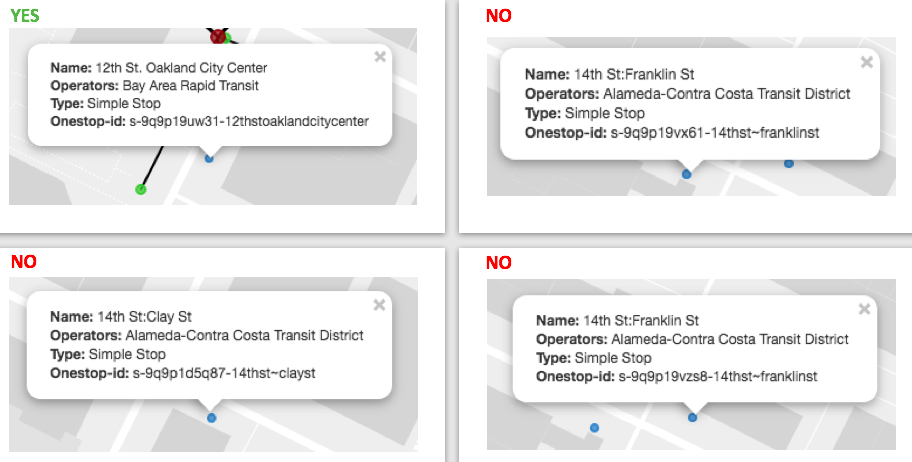

In [226]:
from IPython.display import Image
Image("../images/quadrant.png")

Variables to consider in algorithm:

- Name 1 vs Name 2
- Cross street 1 (if relevant)
- Cross street 2 (if relevant)
- Operator1 != Operator2
- Distance between 1 and 2
- Address 1 vs Address 2
- Coordinates 1 vs Coordinates 2
- Building footprints
- Building heights
- Served by vehicle type [bus, metro, tram, etc]
- Bigger radius by vehicle type
- Draw radius around any stop served by metro, tram or rail or is existing station
- Will and ian to label training data set next week
- Include vehicle type in popup
- Initial similarity matrix (distance *0.5 + name * 0.5)
- Use who's on first
- Stop_transfers

Some questions...

- Is it safe to assume that if the operator of the station is equal to the operator of the simple stop, then the simple stop should not be considered a stop platform (since it would already be categorized as such if its the same operator)

- In other words... should a stop get more similarity points if the operator is different than the station?

# Parse stop record for useful information

In [231]:
from fuzzywuzzy import fuzz

Example string similarity score:

In [252]:
string1 = "14TH ST. & BROADWAY"
string2 = "12th St. Oakland City Center"
fuzz.token_sort_ratio(string1, string2)/100.0

0.51

# Make Similarity Matrix

In [372]:
def make_similarity_matrix(data, distance_matrix):
    
    stations = [i for i in data['stop_stations'] if i['stop_station_type'] == "Station"]
    platforms = [stop_platform for stop_station in data['stop_stations'] for stop_platform in stop_station['stop_platforms'] if stop_platform['generated'] == False]
    simple_stops = [i for i in data['stop_stations'] if i['stop_station_type'] == "Simple Stop"]
    
    # Initialize empty dataframe to store results
    station_ids = [station['onestop_id'] for station in stations]
    simple_stop_ids = [simple_stop['onestop_id'] for simple_stop in simple_stops]
    similarity_matrix = pd.DataFrame(index=station_ids, columns=simple_stop_ids)
    
    # Names dict with onestop_id keys
    names = {}
    for station in stations:
        names[station['onestop_id']] = station['name']
    for simple_stop in simple_stops:
        names[simple_stop['onestop_id']] = simple_stop['name']
    
    # Get distance and name similarity between each station and simple stop pair
    for station_id in station_ids:
        station_name = names[station_id]
        for simple_stop_id in simple_stop_ids:
            simple_stop_name = names[simple_stop_id]
            name_similarity = fuzz.token_sort_ratio(station_name, simple_stop_name)/100.0
            
            distance = distance_matrix.ix[station_id][simple_stop_id]
            inverse_log_distance = 1 / np.log(distance)
            
            similarity_score = (name_similarity * 0.1) + (inverse_log_distance * 0.9)
            similarity_matrix.ix[station_id][simple_stop_id] = similarity_score
            
    return similarity_matrix

In [373]:
%%time

similarity_matrix = make_similarity_matrix(data, distance_matrix)

CPU times: user 49.2 s, sys: 858 ms, total: 50.1 s
Wall time: 50.3 s


In [428]:
similarity_matrix.head()

,s-9q9p616uyb-rockridge,s-9q9p1wrwrp-macarthur,s-9q9p1dwqv1-19thstoakland,s-9q9p19uw31-12thstoaklandcitycenter,s-9q9p145u1w-westoakland,s-9q8znb12j1-embarcadero,s-9q8yyxq427-montgomeryst,s-9q8yywd198-powellst,s-9q8yymt18w-civiccenter~unplaza,s-9q8yy6btqm-16thstmission,...,s-9q9p1wxf72-macarthur,s-9q8yyk3eds-missionst~southvannessave,s-9q8yycs1g5-22ndst~pennsylvaniaave,s-9q8yyct493-22ndst~iowast,s-9q8yycw746-22ndst~minnesotast,s-9q8yycxser-3rdst~22ndst,s-9q8yyct4bq-22ndst~iowast,s-9q8yych5sp-pennsylvaniaavenue~23rdstreet,s-9q8yybskfp-pennsylvaniaavenue~25thstreet,s-9q9ngh8rrh-highst~foothillblvd
s-9q9p1dh9te-14thst~broadway,0.13011,0.137475,0.208934,0.279171,0.160715,0.126589,0.137222,0.135629,0.122118,0.146438,...,0.137475,0.116698,0.125904,0.140997,0.129123,0.136259,0.140997,0.125804,0.129711,0.135044
s-9q9p19eumv-11thst~broadway,0.129442,0.136204,0.200042,0.218248,0.161205,0.126697,0.137332,0.135738,0.122227,0.146556,...,0.136204,0.11681,0.126067,0.141163,0.129292,0.136431,0.141163,0.125969,0.129877,0.135137
s-9q9p19u1u7-12thst~broadway,0.1297,0.136702,0.202969,0.245908,0.16113,0.126665,0.137298,0.135704,0.122192,0.146517,...,0.136702,0.116774,0.13101,0.148105,0.135233,0.143371,0.148105,0.129911,0.133818,0.135079
s-9q9p4ckf4b-fruitvaleave~macarthurblvd,0.1198,0.153495,0.129447,0.134979,0.131708,0.124007,0.112781,0.119407,0.125079,0.110679,...,0.153495,0.123819,0.130808,0.120874,0.121964,0.122059,0.120873,0.129763,0.129723,0.154244
s-9q9p4tc63j-highlandave~highlandway,0.131548,0.12992,0.144528,0.142918,0.141493,0.115628,0.109346,0.116897,0.122508,0.116955,...,0.12992,0.129175,0.133956,0.12302,0.120106,0.119199,0.12302,0.128882,0.128812,0.151773


# Draw Similarity Heatmap

In [374]:
def reindex_matrix(similarity_matrix):
    '''Reindexes row and column names for heatmap'''
    plotdata = similarity_matrix.copy()
    plotdata.reset_index(inplace=True, drop=True)
    plotdata.columns = range(len(plotdata.columns))
    return plotdata

def similarity_heatmap(similarity_matrix, title='Similarity Matrix', filename='heatmap1'):
    '''Creates heatmap from the reindexed similarity matrix'''
    plotdata = reindex_matrix(similarity_matrix)
    
    data = [Heatmap(
        z = plotdata.values.tolist(),
        #zmin = 0,
        #zmax = 1,
        colorscale ='Viridis')]
    
    layout=Layout(
        title = title,
        xaxis = {'title':'Simple Stops'},
        yaxis = {'title':'Stations'}
    )
    
    figure= Figure(data=data,layout=layout)
    return py.iplot(figure, filename=filename)

In [375]:
similarity_heatmap(similarity_matrix)

In [429]:
def compare_records(station_index, simple_stop_index, similarity_matrix, data):
    station_record = filter(lambda i: i['onestop_id'] == list(similarity_matrix.index)[station_index], data['stop_stations'])[0]
    simple_stop_record = filter(lambda i: i['onestop_id'] == list(similarity_matrix.columns)[simple_stop_index], data['stop_stations'])[0]
    
    print "#### Station Record ####"
    print 'Name:', station_record['name']
    print 'Operators:', station_record['operators_serving_stop_and_platforms'][0]['operator_name']
    print 'Served by:', station_record['vehicle_types_serving_stop_and_platforms']
    print 'Onestop-id:', station_record['onestop_id']
    print 'Long, Lat:', station_record['geometry']['coordinates']
    print ""
    print "#### Simple Stop Record ####"
    print 'Name:', simple_stop_record['name']
    print 'Operators:', simple_stop_record['operators_serving_stop_and_platforms'][0]['operator_name']
    print 'Served by:', simple_stop_record['vehicle_types_serving_stop_and_platforms']
    print 'Onestop-id:', simple_stop_record['onestop_id']
    print 'Long, Lat:', simple_stop_record['geometry']['coordinates']
    print ""   
    print 'Similarity Score:', similarity_matrix.ix[station_record['onestop_id']][simple_stop_record['onestop_id']]
    
    return simple_stop_record['geometry']['coordinates']

In [434]:
#loc = compare_records(15, 5364, similarity_matrix, data)
loc = compare_records(13, 10, similarity_matrix, data)

#### Station Record ####
Name: 24TH ST. & MISSION ST.
Operators: Alameda-Contra Costa Transit District
Served by: [u'bus']
Onestop-id: s-9q8yy29g1p-24thst~missionst
Long, Lat: [-122.418206, 37.752327]

#### Simple Stop Record ####
Name: 24th St. Mission
Operators: Bay Area Rapid Transit
Served by: [u'metro']
Onestop-id: s-9q8yy29dff-24thstmission
Long, Lat: [-122.418143, 37.75247]

Similarity Score: 0.409893071906


# View satellite imagery

In [407]:
import cesiumpy
%matplotlib inline

In [436]:
#v = cesiumpy.CesiumWidget()
#v.camera.flyTo((-117.16, 32.71, 15000))
url = '//assets.agi.com/stk-terrain/world'
terrainProvider = cesiumpy.CesiumTerrainProvider(url=url)
v = cesiumpy.Viewer(terrainProvider=terrainProvider)
v.camera.flyTo((loc[0], loc[1], 50))
pin3 = cesiumpy.Pin.fromText('!', color=cesiumpy.color.GREEN)
bill3 = cesiumpy.Billboard(position=[loc[0], loc[1]], image=pin3)
v.entities.add(bill3)

v

In [ ]:
compare_records(15, 5364, similarity_matrix, data)

In [381]:
compare_records(13, 10, similarity_matrix, data)

#### Station Record ####
Name: 24TH ST. & MISSION ST.
Operators: Alameda-Contra Costa Transit District
Served by: [u'bus']
Onestop-id: s-9q8yy29g1p-24thst~missionst

#### Simple Stop Record ####
Name: 24th St. Mission
Operators: Bay Area Rapid Transit
Served by: [u'metro']
Onestop-id: s-9q8yy29dff-24thstmission

Similarity Score: 0.409893071906


In [382]:
compare_records(15, 5364, similarity_matrix, data)

#### Station Record ####
Name: MARKET ST. & SOUTH VAN NESS AVE.
Operators: Alameda-Contra Costa Transit District
Served by: [u'bus']
Onestop-id: s-9q8yykc0k8-marketst~southvannessave

#### Simple Stop Record ####
Name: VAN NESS AVE & MARKET ST
Operators: San Francisco Municipal Transportation Agency
Served by: [u'bus']
Onestop-id: s-9q8yykc08d-vannessave~marketst

Similarity Score: 0.411349937583


In [400]:
compare_records(8, 5553, similarity_matrix, data)

#### Station Record ####
Name: 40TH ST. & SAN PABLO AVE.
Operators: Alameda-Contra Costa Transit District
Served by: [u'bus']
Onestop-id: s-9q9p1qzn8j-40thst~sanpabloave

#### Simple Stop Record ####
Name: 40th at San Pablo
Operators: Emery Go-Round
Served by: [u'bus']
Onestop-id: s-9q9p1qyz5e-40thatsanpablo

Similarity Score: 0.387784551273


In [401]:
compare_records(8, 5575, similarity_matrix, data)

#### Station Record ####
Name: 40TH ST. & SAN PABLO AVE.
Operators: Alameda-Contra Costa Transit District
Served by: [u'bus']
Onestop-id: s-9q9p1qzn8j-40thst~sanpabloave

#### Simple Stop Record ####
Name: 40th at San Pablo
Operators: Emery Go-Round
Served by: [u'bus']
Onestop-id: s-9q9p1qznh4-40thatsanpablo

Similarity Score: 0.388330536028


# Optional: